<a href="https://colab.research.google.com/github/meliy-meyada/Tensorflow-Deep-Learning-and-Artificial-Intelligence/blob/main/TF2_0_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Tensorflow
# !pip install -q tensorflow
try: 
  %tensorflow_version 2.x # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.8.2


In [2]:
# More imports
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2022-07-25 06:16:35--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  27.1MB/s    in 7.7s    

2022-07-25 06:16:43 (24.6 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [4]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [5]:
!ls

ml-20m	ml-20m.zip  sample_data


In [6]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
# The userId and movieId to be numbered 0...N-1

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]
# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [8]:
# Now do same things for movie ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]
# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [9]:
# Get user IDs, movie IDs and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [10]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
K = 10

In [11]:
# Make a neural network

# User input
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # Output is (num_samples, 1, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # Output is (num_samples, 1, K)

# Flatten both embeddings
u_emb = Flatten()(u_emb) # Now it's (num_samples, K)
m_emb = Flatten()(m_emb) # Now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # Now it's (num_samples, 2K)

# Feature vector regular ANN
x = Dense(1024, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
x = Dense(1)(x)

In [12]:
# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
    loss='mse',
    optimizer=SGD(lr=0.08, momentum=0.9),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
# Split the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[:Ntrain]
test_movie = movie_ids[:Ntrain]
test_ratings = ratings[:Ntrain]

# Center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [14]:
r = model.fit(
    x = [train_user, train_movie],
    y = [train_ratings],
    epochs=25,
    batch_size = 1024,
    verbose=2,
    validation_data=([test_user, test_movie], test_ratings),
)

Epoch 1/25
15626/15626 - 70s - loss: 0.7755 - val_loss: 0.7067 - 70s/epoch - 4ms/step
Epoch 2/25
15626/15626 - 66s - loss: 0.7005 - val_loss: 0.6763 - 66s/epoch - 4ms/step
Epoch 3/25
15626/15626 - 66s - loss: 0.6780 - val_loss: 0.6551 - 66s/epoch - 4ms/step
Epoch 4/25
15626/15626 - 65s - loss: 0.6629 - val_loss: 0.6467 - 65s/epoch - 4ms/step
Epoch 5/25
15626/15626 - 65s - loss: 0.6528 - val_loss: 0.6338 - 65s/epoch - 4ms/step
Epoch 6/25
15626/15626 - 65s - loss: 0.6400 - val_loss: 0.6170 - 65s/epoch - 4ms/step
Epoch 7/25
15626/15626 - 65s - loss: 0.6223 - val_loss: 0.5974 - 65s/epoch - 4ms/step
Epoch 8/25
15626/15626 - 66s - loss: 0.6094 - val_loss: 0.5867 - 66s/epoch - 4ms/step
Epoch 9/25
15626/15626 - 65s - loss: 0.5997 - val_loss: 0.5786 - 65s/epoch - 4ms/step
Epoch 10/25
15626/15626 - 65s - loss: 0.5914 - val_loss: 0.5704 - 65s/epoch - 4ms/step
Epoch 11/25
15626/15626 - 65s - loss: 0.5842 - val_loss: 0.5638 - 65s/epoch - 4ms/step
Epoch 12/25
15626/15626 - 65s - loss: 0.5775 - val_l

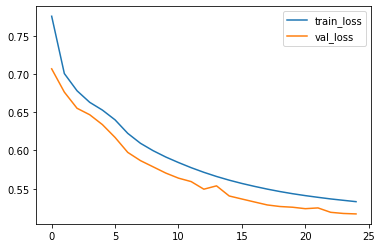

In [16]:
# Plot losses
plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [17]:
np.sqrt(0.6259)

0.7911384202527394